In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import get_train_data
from problem import get_test_data
from catboost import CatBoost, CatBoostClassifier

In [59]:
def compute_rolling_std(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_mean(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "mean", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).mean()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df


def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, True)
    X_df = compute_rolling_std(X_df, feature, time_window, True)
    X_df = compute_rolling_mean(X_df, feature, time_window, False)
    X_df = compute_rolling_std(X_df, feature, time_window, False)
    return X_df

def clip_column(X_df, column, min, max):
    X_df[column] = X_df[column].clip(min, max)
    return X_df

def smoothing(y, factor):
    i=0
    factor = factor
    while i < (y.shape[0]+1-factor):
        if y[:,0][range(i,i+factor)].mean() > 0.5:
            y[:,0][range(i,i+factor)] = 0.99 + 10**-15
            y[:,1][range(i,i+factor)] = 0.01 - 10**-15
        else:
            y[:,0][range(i,i+factor)] = 0.01 - 10**-15
            y[:,1][range(i,i+factor)] = 0.99 + 10**-15
        i+=factor
    return y

def smoothing2(y, factor):
    i=0
    factor = factor
    while i < (y.shape[0]+1-factor):
        y[:,0][range(i,i+factor)] = y[:,0][range(i,i+factor)].mean()
        y[:,1][range(i,i+factor)] = y[:,1][range(i,i+factor)].mean()
        i+=factor
    return y

def smoothingp(y, factor):
    i=0
    factor = 18
    while i < (y.shape[0]+1-factor):
        y[range(i, i+factor)] = 0
        i+=factor
    return y
    
def smoothingroll(y, factor):
    y2 = y.copy()
    i=factor
    factor = factor
    while i < (y.shape[0]+1-factor):
        y2[:,0][i] = (y[:,0][range(i-factor,i+factor)].mean())
        y2[:,1][i] = (y[:,1][range(i-factor,i+factor)].mean())
        i+=1
    return y2


def transform(X):
    X = clip_column(X, 'Beta', 0, 500)
    X = clip_column(X, "B", 0, 1000)
    X = clip_column(X, "RmsBob", 0, 20)
    X = clip_column(X, "Vth", 0, 200)
    X = clip_column(X, "Vx", 0, 500)
    X = clip_column(X, "Np", 0, 100)
    X = clip_column(X, "Range F 13", 0, 10**9)
    Cols = ["B", "Beta", "RmsBob", "V", "Vth", "Range F 13"]
    X = X.drop(columns=[col for col in X if col not in Cols])
    Cols = ["B", "Beta", "RmsBob", "V", "Vth"]
    for i in Cols:
        for j in ["1h", "2h", "3h", "4h", "5h", "6h", "12h", '18h', "24h", "48h", '72h', '96h']:
            X = compute_rolling_variables(X, i, j)
        X = X.copy()
    # X = compute_rolling_mean(X, "Range F 13", "24h", True)
    X = compute_rolling_std(X, "Range F 13", "24h", True)
    # X = compute_rolling_mean(X, "Range F 13", "24h", False)
    # X = compute_rolling_std(X, "Range F 13", "24h", False)
    # X = compute_rolling_mean(X, "Range F 13", "48h", True)
    X = compute_rolling_std(X, "Range F 13", "48h", True)
    # X = compute_rolling_mean(X, "Range F 13", "48h", False)
    # X = compute_rolling_std(X, "Range F 13", "48h", False)

    # X = compute_rolling_mean(X, "Range F 9", "24h", True)
    # X = compute_rolling_std(X, "Range F 9", "24h", True)
    # X = compute_rolling_mean(X, "Range F 9", "24h", False)
    # X = compute_rolling_std(X, "Range F 9", "24h", False)
    # X = compute_rolling_mean(X, "Range F 9", "48h", True)
    # X = compute_rolling_std(X, "Range F 9", "48h", True)
    # X = compute_rolling_mean(X, "Range F 9", "48h", False)
    # X = compute_rolling_std(X, "Range F 9", "48h", False)

    # X = compute_rolling_mean(X, "Vth", "24h", True)
    # X = compute_rolling_std(X, "Vth", "24h", True)
    # X = compute_rolling_mean(X, "Vth", "24h", False)
    # X = compute_rolling_std(X, "Vth", "24h", False)
    # X = compute_rolling_mean(X, "Vth", "48h", True)
    # X = compute_rolling_std(X, "Vth", "48h", True)
    # X = compute_rolling_mean(X, "Vth", "48h", False)
    # X = compute_rolling_std(X, "Vth", "48h", False)

    # X = X.drop(columns=["Range F 13", "Range F 9"])
    return X

In [60]:
X, y = get_train_data()
Xt, yt = get_test_data()
X = transform(X)
Xt = transform(Xt)

In [61]:
cat = CatBoostClassifier(iterations=300,
                                depth=5,
                                l2_leaf_reg=3,
                                loss_function='Logloss',
                                auto_class_weights='SqrtBalanced',
                                learning_rate=0.05,
                                logging_level='Silent',
                                task_type="CPU")

In [62]:
cat.fit(
    X,
    y=y,
    verbose=100,
    eval_set=(Xt, yt),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

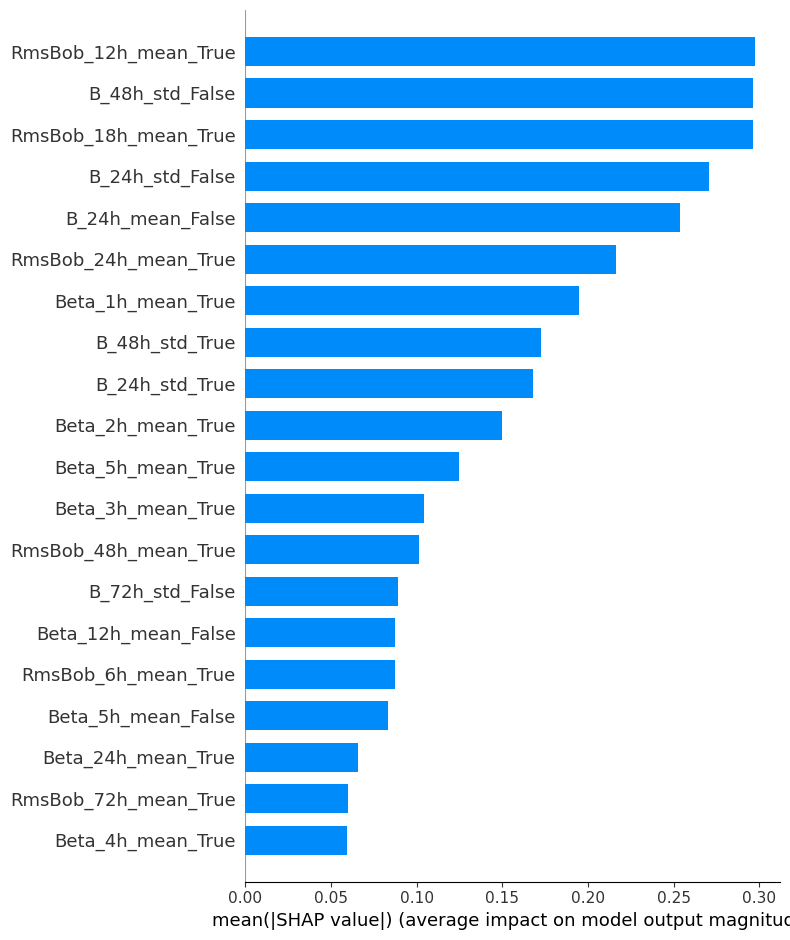

In [63]:
import shap
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type='bar', class_names=cat.classes_, feature_names=X.columns)